# Scan LL for a granule

In [92]:
# imports
import os
import numpy as np
from matplotlib import pyplot as plt

import xarray

from ulmo import io as ulmo_io
from ulmo.preproc import extract
from ulmo.preproc import utils as pp_utils

# Load data

In [2]:
dpath = '/home/xavier/Projects/Oceanography/AI/OOD/Scan'

## Mask

In [3]:
xd_mask = xarray.load_dataset(os.path.join(dpath, 'TempMask2.nc'))

In [4]:
xd_mask

<xarray.Dataset>
Dimensions:   (x: 1354, y: 2030)
Dimensions without coordinates: x, y
Data variables:
    new_mask  (y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0

## Reset so 0=good, 1=bad

In [101]:
msk = xd_mask.new_mask.data.astype(int)

In [102]:
msk.shape

(2030, 1354)

In [103]:
msk

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

## Data

In [9]:
data_file = os.path.join(dpath, 'AQUA_MODIS.20100619T062008.L2.SST.nc')

In [10]:
xd_data = xarray.load_dataset(data_file)
xd_data

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*
Attributes:
    title:                          MODISA Level-2 Data
    product_name:                   AQUA_MODIS.20100619T062008.L2.SST.nc
    processing_version:             R2019.0
    equatorCrossingLongitude:       -73.879005
    orbit_number:                   43222
    history:                        l2gen par=/data11/sdpsoper/vdc/vpu22/work...
    instrument:                     MODIS
    platform:                       Aqua
    Conventions:                    CF-1.6 ACDD-1.3
    license:                        https://science.nasa.gov/earth-science/ea...
    naming_authority:               gov.nasa.gsfc.sci.oceandata
    id:                             R2019.0/L2/AQUA_MODIS.20100619T062008.L2....
    date_created:                   2019-11-29T23:12:39.000Z
    keywords_vocabulary:            NASA Global Change Master Directory (GCMD...
    keywords:                       Earth Science > Oceans > Ocean Optics > S...
    standard_name_vocabulary:       CF Standard Name Table v36
    institution:                    NASA Goddard Space Flight Center, Ocean E...
    creator_name:                   NASA/GSFC/OBPG
    creator_email:                  data@oceancolor.gsfc.nasa.gov
    creator_url:                    https://oceandata.sci.gsfc.nasa.gov
    project:                        Ocean Biology Processing Group (NASA/GSFC...
    publisher_name:                 NASA/GSFC/OBPG
    publisher_url:                  https://oceandata.sci.gsfc.nasa.gov
    publisher_email:                data@oceancolor.gsfc.nasa.gov
    processing_level:               L2
    cdm_data_type:                  swath
    equatorCrossingDateTime:        2010-06-19T06:32:11.004Z
    spatialResolution:              1 km
    time_coverage_start:            2010-06-19T06:20:01.812Z
    time_coverage_end:              2010-06-19T06:25:00.189Z
    start_center_longitude:         -62.915764
    start_center_latitude:          43.941067
    end_center_longitude:           -68.0871
    end_center_latitude:            25.968895
    northernmost_latitude:          45.149097
    southernmost_latitude:          23.831848
    easternmost_longitude:          -49.258347
    westernmost_longitude:          -79.7044
    geospatial_lat_units:           degrees_north
    geospatial_lon_units:           degrees_east
    geospatial_lat_max:             45.149097
    geospatial_lat_min:             23.831848
    geospatial_lon_max:             -49.258347
    geospatial_lon_min:             -79.7044
    startDirection:                 Descending
    endDirection:                   Descending
    day_night_flag:                 Night
    earth_sun_distance_correction:  0.9685534834861755

In [23]:
sst_tot, qual, latitude, longitude = ulmo_io.load_nc(data_file)

In [24]:
sst_tot.shape

(2030, 1354)

# Restrict to near nadir

In [14]:
nadir_offset=480

In [104]:
# Restrict to near nadir
nadir_pix = sst.shape[1] // 2
lb = nadir_pix - nadir_offset
ub = nadir_pix + nadir_offset
sst = sst_tot[:, lb:ub]
mask = msk[:, lb:ub].astype(np.uint8)

# Find all the clear places

In [71]:
field_size = (128,128)

In [108]:
# Sum across the image
CC_mask = extract.uniform_filter(mask.astype(float), field_size[0], mode='constant', cval=1.)

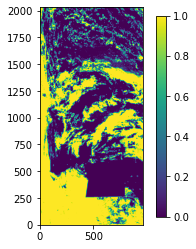

In [109]:
plt.clf()
mpl = plt.imshow(mask, origin='lower')
cb = plt.colorbar(mpl, fraction=0.030, pad=0.04)
plt.show()

In [110]:
CC_mask

array([[1.        , 1.        , 1.        , ..., 0.99383545, 0.99383545,
        0.99383545],
       [1.        , 1.        , 1.        , ..., 0.99383545, 0.99383545,
        0.99383545],
       [1.        , 1.        , 1.        , ..., 0.99383545, 0.99383545,
        0.99383545],
       ...,
       [0.86663818, 0.86431885, 0.86193848, ..., 0.84564209, 0.84838867,
        0.85137939],
       [0.86895752, 0.86663818, 0.86425781, ..., 0.84875488, 0.85144043,
        0.85437012],
       [0.87133789, 0.86901855, 0.86663818, ..., 0.85150146, 0.85412598,
        0.85699463]])

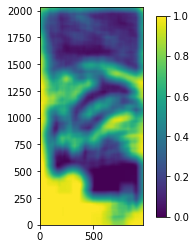

In [111]:
plt.clf()
mpl2 = plt.imshow(CC_mask, origin='lower')
cb = plt.colorbar(mpl2, fraction=0.030, pad=0.04)
plt.show()

## Assess

In [112]:
CC_max=0.05

In [113]:
# Clear
mask_edge = np.zeros_like(mask)#, dtype=bool)
mask_edge[:field_size[0]//2,:] = True
mask_edge[-field_size[0]//2:,:] = True
mask_edge[:,-field_size[0]//2:] = True
mask_edge[:,:field_size[0]//2] = True
clear = (CC_mask < CC_max) & np.logical_not(mask_edge)

# Indices
idx_clear = np.where(clear)
nclear = idx_clear[0].size
nclear

117654

## Offset to lower left corner

In [114]:
picked_row = idx_clear[0] - field_size[0]//2
picked_col = idx_clear[1] - field_size[0]//2

# Extract

In [115]:
rows = picked_row
cols = picked_col
clear_fracs = CC_mask[idx_clear]

In [116]:
rows

array([ 253,  253,  253, ..., 1829, 1829, 1830])

In [117]:
masks = mask.copy()

In [118]:
inpaint = True

In [119]:
# Extract
fields, field_masks = [], []
metadata = []
count = 0
for r, c, clear_frac in zip(rows, cols, clear_fracs):
    if (count % 100) == 0:
        print(count)
    # Inpaint?
    field = sst[r:r+field_size[0], c:c+field_size[1]]
    mask = masks[r:r+field_size[0], c:c+field_size[1]]
    if inpaint:
        field, _ = pp_utils.preproc_field(field, mask, only_inpaint=True)
    if field is None:
        continue
    # Append SST and mask
    fields.append(field.astype(np.float32))
    field_masks.append(mask)
    # meta
    row, col = r, c + lb
    lat = latitude[row + field_size[0] // 2, col + field_size[1] // 2]
    lon = longitude[row + field_size[0] // 2, col + field_size[1] // 2]
    metadata.append([data_file, str(row), str(col), str(lat), str(lon), str(clear_frac)])
    count += 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18